In [1]:
import os
import cv2
from deepface import DeepFace
#from deepface.modules import functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Local descriptors
from skimage.feature import hog, local_binary_pattern
from skimage import  exposure
from skimage import feature

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# Beispiel für die Verwendung von ArcFace-Embeddings in einem Klassifikator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
def GetPredictions(X_train, X_test, y_train, y_test, model, parameters):
    model_name = type(model).__name__
    print(f"{model_name} training...")
    t0 = time()
    
    # Grid search across parameter range
    clf = GridSearchCV(model, parameters, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(X_test)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

In [3]:
def calc_embs(model, X):
    pd = []
    for image in X:
        img_embedding = DeepFace.represent(img_path=image, model_name='ArcFace', enforce_detection=False)
        pd.append(img_embedding[0]['embedding'])
    return np.array(pd)

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [4]:
def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    try:
        cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")


In [5]:
# Data location
folder = "data/rvf10k/train"
dest_folder = "data/roi_dataset"
cascade_path = "data/haarcascade_frontalface_default.xml"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []

n_images = 0

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))

            # Extract face as ROI
            faceCascade = cv2.CascadeClassifier(cascade_path)
            faces = faceCascade.detectMultiScale(
                image,
                scaleFactor=1.3,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) > 0:
                for x, y, w, h in faces:
                    image = image[y:y + h, x:x + w]
                    save_image_with_error_handling(dest_folder, class_name, n_images, image)
                    n_images += 1
            else:
                cv2.imwrite(
                    os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
                n_images += 1

An error occurred while saving image 2979: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 4222: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 5718: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 6045: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'



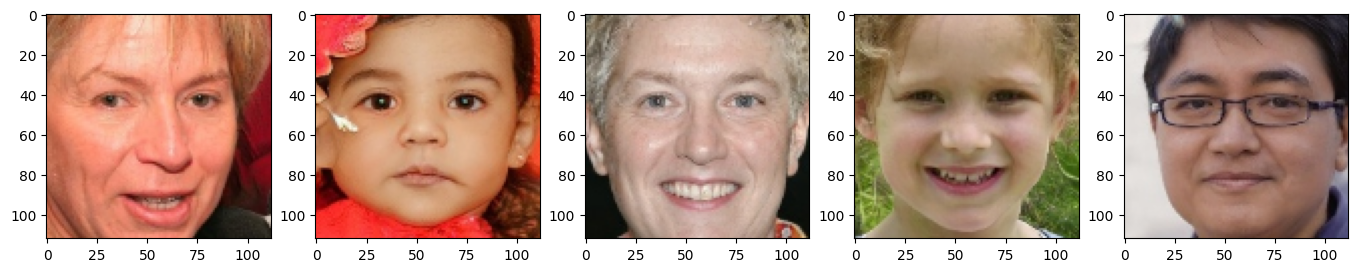

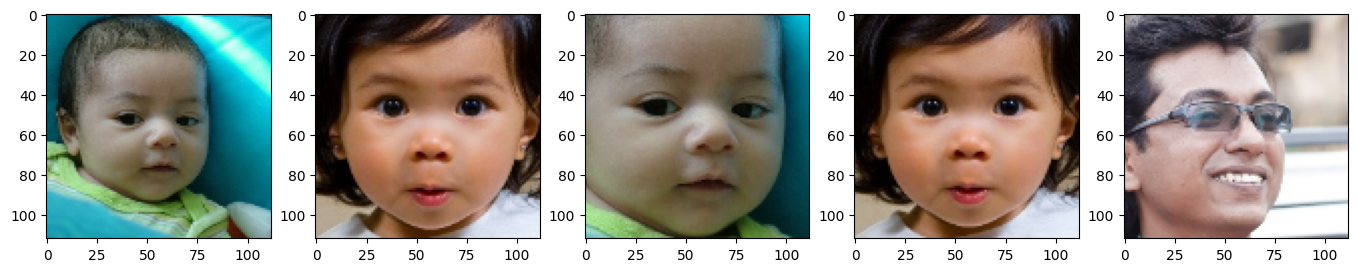

Features
(7008, 512)
(7008,)


In [6]:
# Deepface
# Available models ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model_deepface = DeepFace.build_model("ArcFace")

target_size = (112, 112)  # Beispielgröße, kann je nach Modell und Anwendung variieren

#target_size = (model_deepface.input_shape[0], model_deepface.input_shape[1])
dim = (int(target_size[0]), int(target_size[1]))

folder = "data/roi_dataset"
nclasses = 0
nperclass = []
classlabels = []
X = []
Y = []
XFaceNet = []
dpi = matplotlib.rcParams['figure.dpi']
nims2show = 5

for class_name in os.listdir(folder):
    nclasses += 1
    nsamples = 0
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith('.jpg'):
            image = cv2.imread(os.path.join(class_folder, file_name))
            image = cv2.resize(image, target_size)
            
            # Flatten the image to a single vector
            X.append(image.flatten())
            
            # DeepFace with ArcFace
            img_embedding = calc_embs(model_deepface, [os.path.join(class_folder, file_name)])
            XFaceNet.append(img_embedding[0])
                    
            Y.append(nclasses - 1)
            
            # Show the first nims2show samples of each class
            if nsamples < nims2show:
                if nsamples == 0:
                    height, width, depth = image.shape
                    figsize = 15 * width / float(dpi), 15 * height / float(dpi)
                    fig = plt.figure(figsize=figsize)
                
                fig.add_subplot(1, nims2show, nsamples + 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)

X = np.array(X, dtype='float64')
Y = np.array(Y, dtype='float64')
XFaceNet = np.array(XFaceNet, dtype='float32')

print("Features")
print(XFaceNet.shape)
print(Y.shape)
class_names = np.array(classlabels)
n_classes = class_names.shape[0]


In [7]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

# Store file paths
file_paths = []
for class_name in os.listdir(folder):
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith('.jpg'):
            file_paths.append(os.path.join(class_folder, file_name))

folds = [[] for _ in range(5)]

fold = 1
for train_index, test_index in skf.split(X, Y):
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    
    fold_files = [file_paths[i] for i in test_index]
    folds[fold - 1] = fold_files
    
    fold += 1

# Save file paths to a file
with open('folds.txt', 'w') as f:
    for i, fold_files in enumerate(folds):
        f.write(f"Files in fold {i + 1}:\n")
        for file_path in fold_files:
            f.write(file_path + '\n')
        f.write('\n')

# Folds are also saved in the variable 'folds'

Fold 1
# samples in training set 5606
# samples in test set 1402
Fold 2
# samples in training set 5606
# samples in test set 1402
Fold 3
# samples in training set 5606
# samples in test set 1402
Fold 4
# samples in training set 5607
# samples in test set 1401
Fold 5
# samples in training set 5607
# samples in test set 1401


+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 99.258s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.640s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.90      0.87      0.88       701
        real       0.87      0.90      0.89       701

    accuracy                           0.89      1402
   macro avg       0.89      0.89      0.89      1402
weighted avg       0.89      0.89      0.89      1402

Confusion matrix for Facenet + SVM:
[[609  92]
 [ 69 632]]


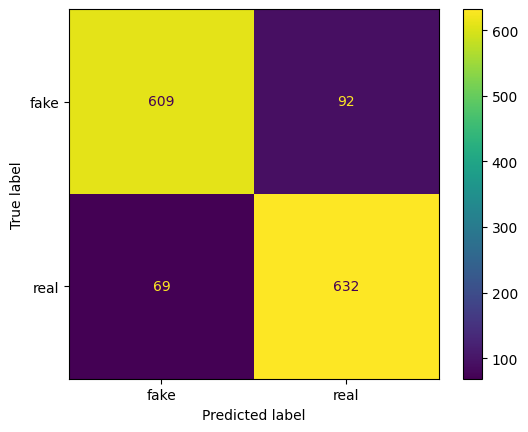

RandomForestClassifier training...
done in 161.417s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.033s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.88      0.79      0.83       701
        real       0.81      0.89      0.85       701

    accuracy                           0.84      1402
   macro avg       0.85      0.84      0.84      1402
weighted avg       0.85      0.84      0.84      1402

Confusion matrix for Facenet + RF:
[[553 148]
 [ 74 627]]


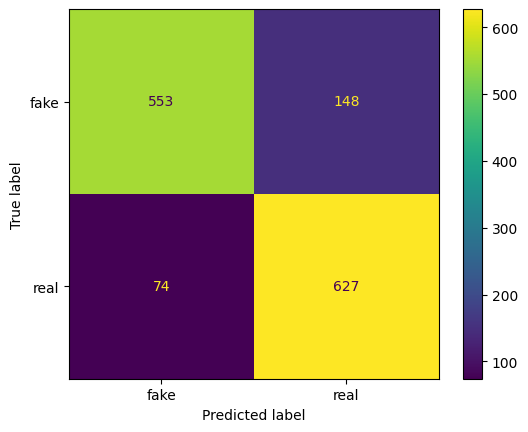

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 98.373s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.636s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.88      0.90      0.89       701
        real       0.89      0.88      0.89       701

    accuracy                           0.89      1402
   macro avg       0.89      0.89      0.89      1402
weighted avg       0.89      0.89      0.89      1402

Confusion matrix for Facenet + SVM:
[[628  73]
 [ 83 618]]


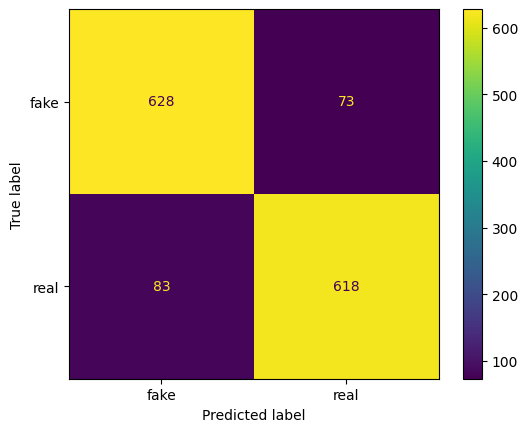

RandomForestClassifier training...
done in 162.998s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.033s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.85      0.80      0.83       701
        real       0.81      0.86      0.84       701

    accuracy                           0.83      1402
   macro avg       0.83      0.83      0.83      1402
weighted avg       0.83      0.83      0.83      1402

Confusion matrix for Facenet + RF:
[[562 139]
 [ 96 605]]


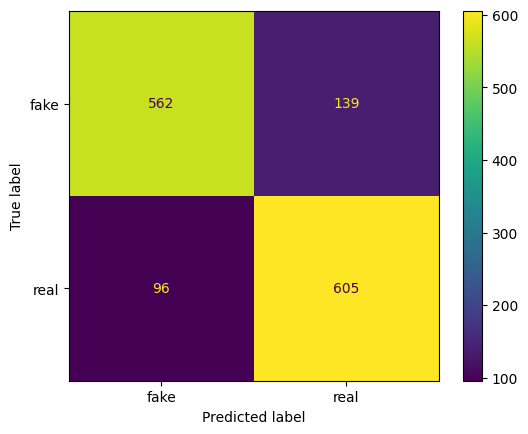

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 98.053s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.654s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.90      0.88      0.89       700
        real       0.88      0.90      0.89       702

    accuracy                           0.89      1402
   macro avg       0.89      0.89      0.89      1402
weighted avg       0.89      0.89      0.89      1402

Confusion matrix for Facenet + SVM:
[[618  82]
 [ 72 630]]


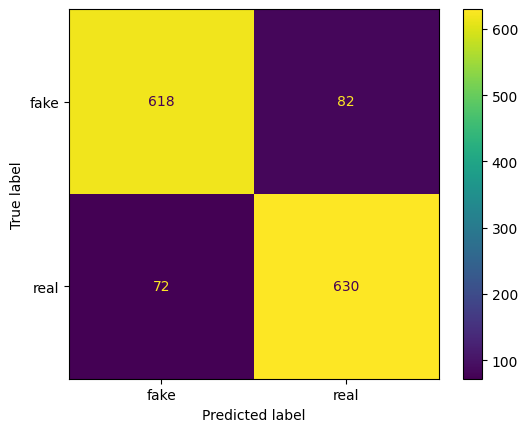

RandomForestClassifier training...
done in 162.884s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.035s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.87      0.79      0.83       700
        real       0.81      0.88      0.84       702

    accuracy                           0.84      1402
   macro avg       0.84      0.84      0.84      1402
weighted avg       0.84      0.84      0.84      1402

Confusion matrix for Facenet + RF:
[[556 144]
 [ 84 618]]


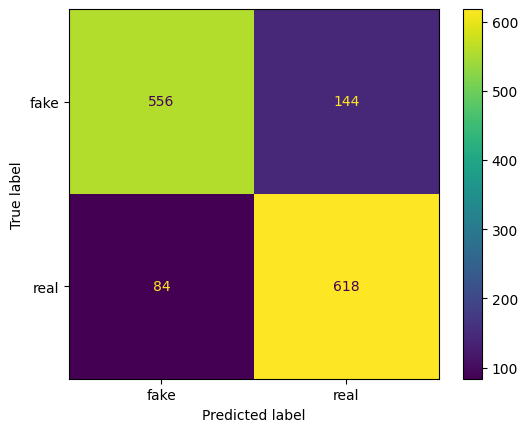

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 100.334s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.676s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.89      0.89      0.89       700
        real       0.89      0.89      0.89       701

    accuracy                           0.89      1401
   macro avg       0.89      0.89      0.89      1401
weighted avg       0.89      0.89      0.89      1401

Confusion matrix for Facenet + SVM:
[[625  75]
 [ 80 621]]


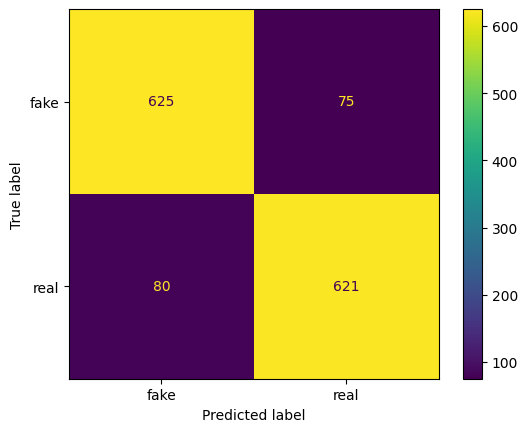

RandomForestClassifier training...
done in 162.397s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.033s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.85      0.82      0.83       700
        real       0.82      0.85      0.84       701

    accuracy                           0.84      1401
   macro avg       0.84      0.84      0.84      1401
weighted avg       0.84      0.84      0.84      1401

Confusion matrix for Facenet + RF:
[[571 129]
 [102 599]]


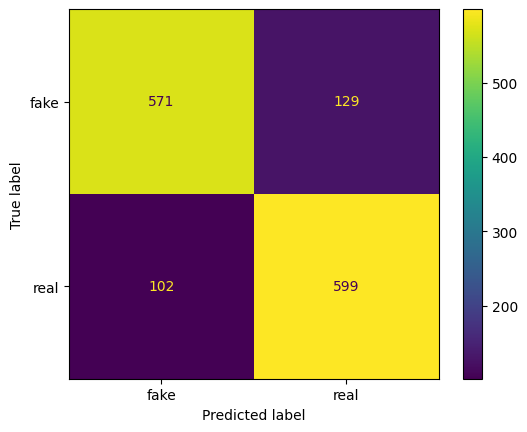

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 100.266s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.638s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.88      0.89      0.89       700
        real       0.89      0.88      0.89       701

    accuracy                           0.89      1401
   macro avg       0.89      0.89      0.89      1401
weighted avg       0.89      0.89      0.89      1401

Confusion matrix for Facenet + SVM:
[[622  78]
 [ 81 620]]


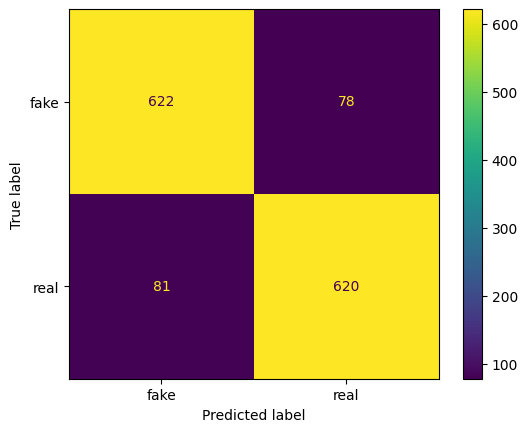

RandomForestClassifier training...
done in 162.588s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.034s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.85      0.83      0.84       700
        real       0.84      0.86      0.85       701

    accuracy                           0.85      1401
   macro avg       0.85      0.85      0.85      1401
weighted avg       0.85      0.85      0.85      1401

Confusion matrix for Facenet + RF:
[[583 117]
 [100 601]]


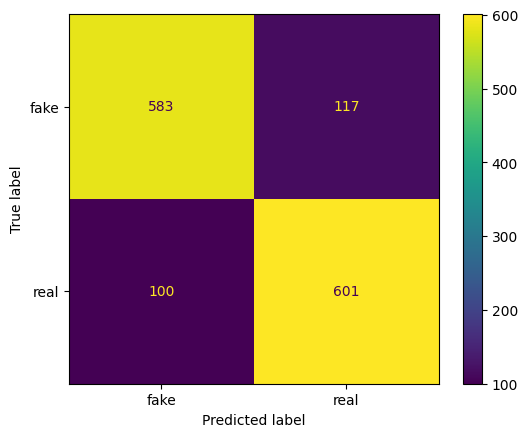

In [8]:
print("+++++++++++++++++++++++++++++++++++++++++++\n")

# KNN 
precs_facenet_svm, recs_facenet_svm, acc_facenet_svm = [], [], []
precs_facenet_rf, recs_facenet_rf, acc_facenet_rf = [], [], []

SVM = SVC(kernel='rbf', class_weight='balanced')
SVM_parameters = {
    'C': [1e3, 5e3],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
}

RF = RandomForestClassifier()
RF_parameters = {
    'n_estimators': [100, 150, 200],
}

fold = 1
skf = StratifiedKFold(n_splits=5)
scaler = StandardScaler()



for train_index, test_index in skf.split(XFaceNet, Y):
    print("*********************\nFold %d" % fold)
        
    X_train, X_test = XFaceNet[train_index], XFaceNet[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Scale data only for SVM
    X_train_svm = scaler.fit_transform(X_train)
    X_test_svm = scaler.transform(X_test)
    
    # Facenet - SVM
    print("\nDeepface/Facenet")
    y_pred, y_test = GetPredictions(X_train_svm, X_test_svm, y_train, y_test, SVM, SVM_parameters)
    print("\nDeepface/Facenet + SVM Metrics")
    precs_facenet_svm.append(precision_score(y_test, y_pred, average='weighted'))
    recs_facenet_svm.append(recall_score(y_test, y_pred, average='weighted'))
    acc_facenet_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for Facenet + SVM:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
        
    # Facenet - Random Forest
    y_pred, y_test = GetPredictions(X_train, X_test, y_train, y_test, RF, RF_parameters)
    print("\nDeepface/Facenet + RF Metrics")
    precs_facenet_rf.append(precision_score(y_test, y_pred, average='weighted'))
    recs_facenet_rf.append(recall_score(y_test, y_pred, average='weighted'))
    acc_facenet_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for Facenet + RF:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

In [ ]:
# Analyze images. Save imagepath to another file if no face found. Summarize results
analysis_results = []
failed_images = []

for i, fold_files in enumerate(folds):
    fold_results = defaultdict(lambda: defaultdict(int))
    for file_path in fold_files:
        try:
            objs = DeepFace.analyze(img_path=file_path, actions=['age', 'gender', 'race', 'emotion'])
            for obj in objs:  # iterate through the list of analysis results
                for key, value in obj.items():
                    if key in ['age', 'gender', 'race', 'emotion']:
                        if isinstance(value, dict):  # e.g., emotion analysis returns a dictionary
                            for sub_key, sub_value in value.items():
                                fold_results[key][sub_key] += sub_value
                        else:
                            fold_results[key][value] += 1
        except ValueError as e:
            print(f"Failed to analyze {file_path}: {e}")
            failed_images.append(file_path)
    analysis_results.append(fold_results)

# Save analysis results to a file
with open('analysis_summary.txt', 'w') as f:
    for i, fold_results in enumerate(analysis_results):
        f.write(f"Summary for fold {i + 1}:\n")
        for key, value in fold_results.items():
            f.write(f"{key}:\n")
            for sub_key, sub_value in value.items():
                f.write(f"  {sub_key}: {sub_value}\n")
        f.write('\n')

# Save failed images to a file
with open('failed_images.txt', 'w') as f:
    f.write("Images where face detection failed:\n")
    for file_path in failed_images:
        f.write(file_path + '\n')

# Print analysis results (optional)
for i, fold_results in enumerate(analysis_results):
    print(f"Summary for fold {i + 1}:")
    for key, value in fold_results.items():
        print(f"{key}:")
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    print('\n')

# Print failed images (optional)
print("Images where face detection failed:")
for file_path in failed_images:
    print(file_path)